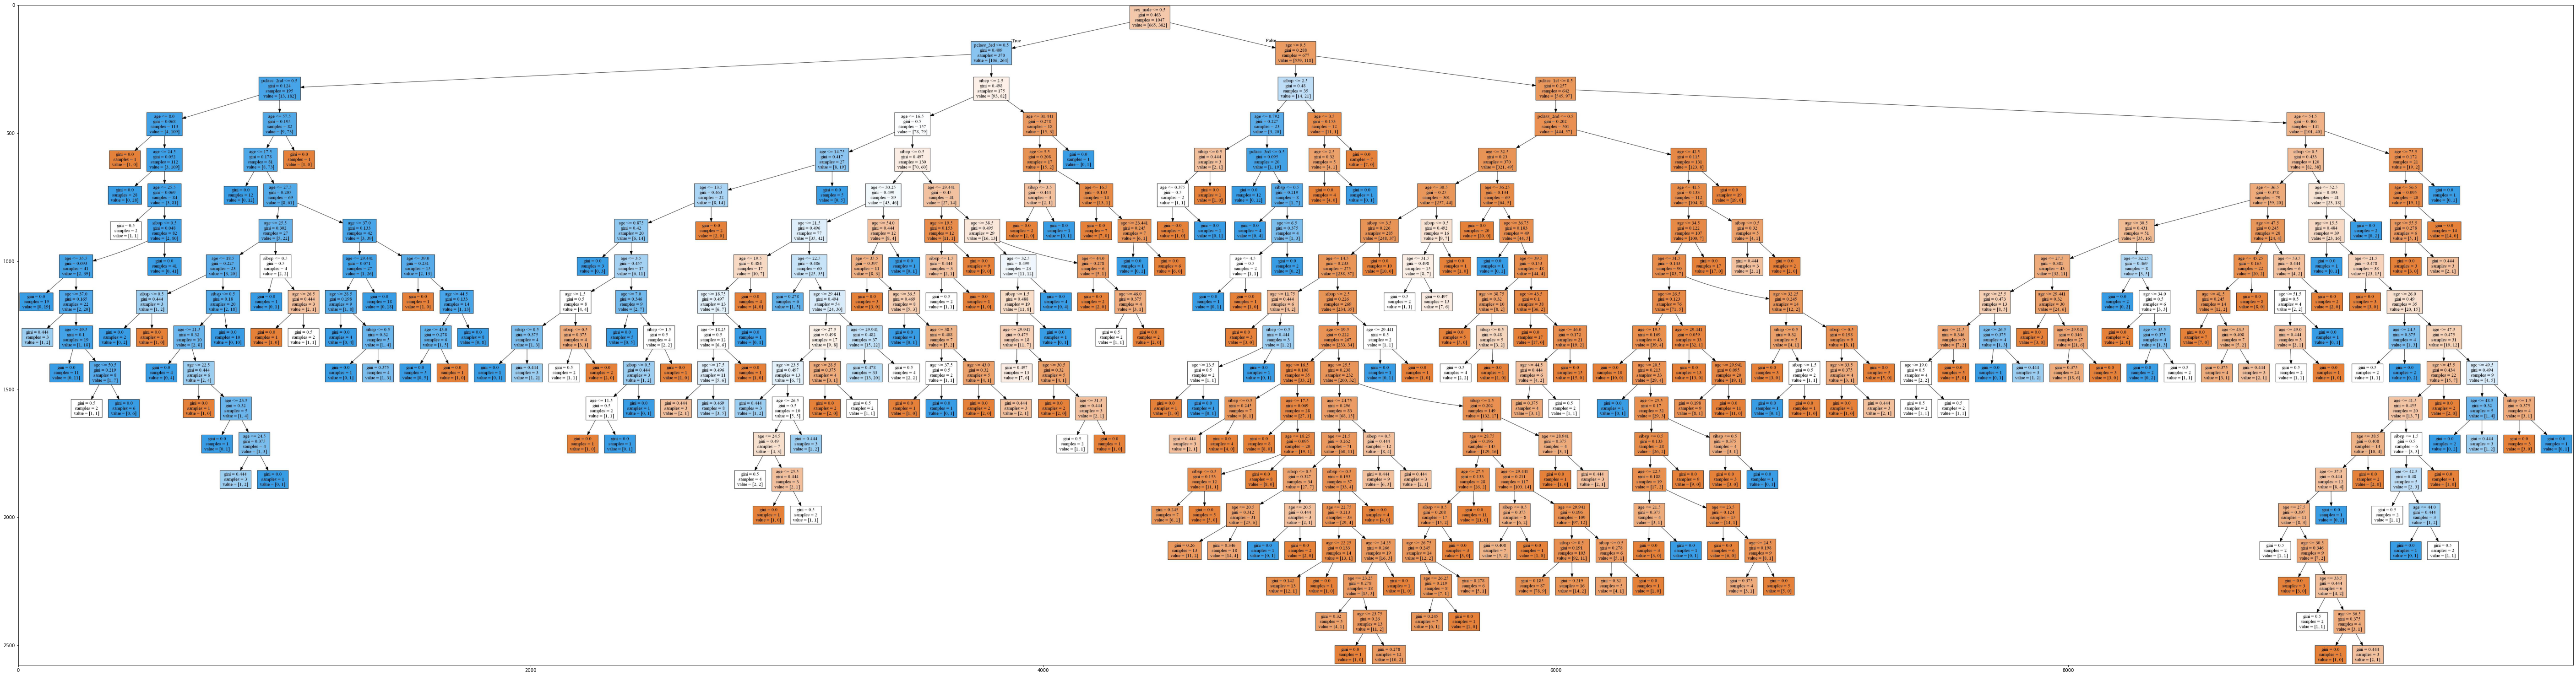

In [1]:
# from sklearn.tree import DecisionTreeRegressor
import pandas as pd
from sklearn import tree

# tree.DecisionTreeClassifier()  # for classification tree
# tree.DecisionTreeRegressor()   # for regression tree
  
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split    # K-fold cross validation
from sklearn.preprocessing import LabelEncoder as LE
from pydotplus import graph_from_dot_data

#  reading and analysing data

dataset = pd.read_csv(r"C:\Users\sandip\Desktop\Stevens_study_material\CPE695\hw3\Titanic.csv", usecols=[1,2,4,5,6])
column_headers = dataset.columns.values.tolist()            # to get the names of the column headers used, in a list
columns_with_null_values = []
for column in column_headers:
    if dataset[column].isnull().values.any():
        columns_with_null_values.append(column)

dataset = pd.get_dummies(dataset, columns =['pclass', 'sex'])
dataset['survived'] = LE().fit_transform(dataset['survived'])   # implementing LabelEncoder() for fitting

for null_column in columns_with_null_values:
    mean = dataset[null_column].mean(skipna = True)  
    dataset[null_column].fillna(mean, inplace = True)     # To fill inexistent qty with mean of the column

X_train, X_test, Y_train, Y_test = train_test_split(dataset.iloc[:,1:] , dataset.iloc[:,0] , test_size = 0.2, random_state = 42)   # STEP 1

decision_tree = tree.DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, Y_train)
display_tree = tree.export_graphviz(decision_tree, feature_names = X_train.columns.values, out_file = None, filled = True)
pydot_garph = graph_from_dot_data(display_tree)
pydot_garph.write_jpg('decision_tree_unpruned.jpg')
img = plt.imread('decision_tree_unpruned.jpg')
plt.figure(figsize = (100,50))
plt.imshow(img)

In [2]:
from sklearn.metrics import confusion_matrix
import numpy as np
from numpy import asarray
import seaborn
from sklearn.metrics import zero_one_loss

y_predicted_train = decision_tree.predict(X_train)
confusion_matrix_train = confusion_matrix(Y_train, y_predicted_train)
print(confusion_matrix_train)

group_percentages = ['{0:.4%}'.format(value) for value in confusion_matrix_train.flatten()/np.sum(confusion_matrix_train)]

print('percentage of in sample survivors predicted correctly:', group_percentages[0])
print('percentage of in sample fatalities predicted correctly:', group_percentages[3])
print('MIsclassified(training data - whole tree):', confusion_matrix_train[0][1] + confusion_matrix_train[1][0])

y_predicted_test = decision_tree.predict(X_test)
confusion_matrix_test = confusion_matrix(Y_test, y_predicted_test)
print(confusion_matrix_test)

group_percentages_test = ['{0:.4%}'.format(value) for value in confusion_matrix_test.flatten()/np.sum(confusion_matrix_test)] 

print('percentage of out-of-sample survivors correctly predicted:', group_percentages_test[0])
print('percentage of out-of-sample fatalities correctly predicted:', group_percentages_test[3])
print('MIsclassified (testing data - whole tree):', confusion_matrix_test[0][1] + confusion_matrix_test[1][0])

[[640  25]
 [ 88 294]]
percentage of in sample survivors predicted correctly: 61.1270%
percentage of in sample fatalities predicted correctly: 28.0802%
MIsclassified(training data - whole tree): 113
[[128  16]
 [ 49  69]]
percentage of out-of-sample survivors correctly predicted: 48.8550%
percentage of out-of-sample fatalities correctly predicted: 26.3359%
MIsclassified (testing data - whole tree): 65


In [3]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

max_leaf_nodes = np.arange(2, 10)
parameters_for_best_tree= {'max_leaf_nodes': max_leaf_nodes, 'max_depth': np.arange(1, 20), 'min_samples_leaf': [1, 5, 7, 10], 'min_samples_split': [2, 10, 20]}

grid = GridSearchCV(tree.DecisionTreeClassifier(random_state = 42), param_grid = parameters_for_best_tree, cv = KFold(n_splits = 10), return_train_score = True) 
grid.fit(X_train, Y_train)

print('Best Parameters:', grid.best_params_)
print('Best Score:', grid.best_score_)
print('Best Estimator:', grid.best_estimator_)
print('Training set score:', grid.score(X_train, Y_train))
print('Testing set score:', grid.score(X_test, Y_test))


Best Parameters: {'max_depth': 3, 'max_leaf_nodes': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score: 0.8127014652014651
Best Estimator: DecisionTreeClassifier(max_depth=3, max_leaf_nodes=5, random_state=42)
Training set score: 0.8127984718242598
Testing set score: 0.7442748091603053


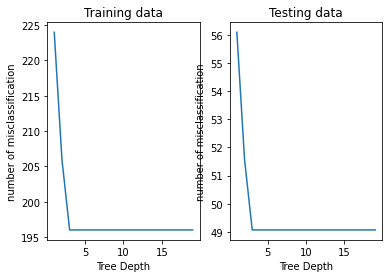

In [4]:
tree_depth = []
misclassification_train, misclassification_test = [], []
params = grid.cv_results_['params']

#grid_cv_results.keys() => mean_fit_time, std_fit_time, ... mean_train_scores,std_test_scores, etc.
for i in range(len(params)):
    if params[i]['max_leaf_nodes'] == grid.best_params_['max_leaf_nodes'] and params[i]['min_samples_split'] == grid.best_params_['min_samples_split'] and \
    params[i]['min_samples_leaf'] == grid.best_params_['min_samples_leaf']:
        tree_depth.append(params[i]['max_depth'])
        train_wrong = len(X_train) - grid.cv_results_['mean_train_score'][i]*len(X_train)
        test_wrong = len(X_test) - grid.cv_results_['mean_test_score'][i]*len(X_test)
        misclassification_train.append(train_wrong)
        misclassification_test.append(test_wrong)

plt.subplot(1,2,1)
plt.xlabel('Tree Depth')
plt.ylabel('number of misclassification')
plt.title('Training data')
plt.plot(tree_depth,misclassification_train)
    
plt.subplot(1,2,2)   
plt.xlabel('Tree Depth')
plt.ylabel('number of misclassification')
plt.title('Testing data')

plt.plot(tree_depth,misclassification_test)

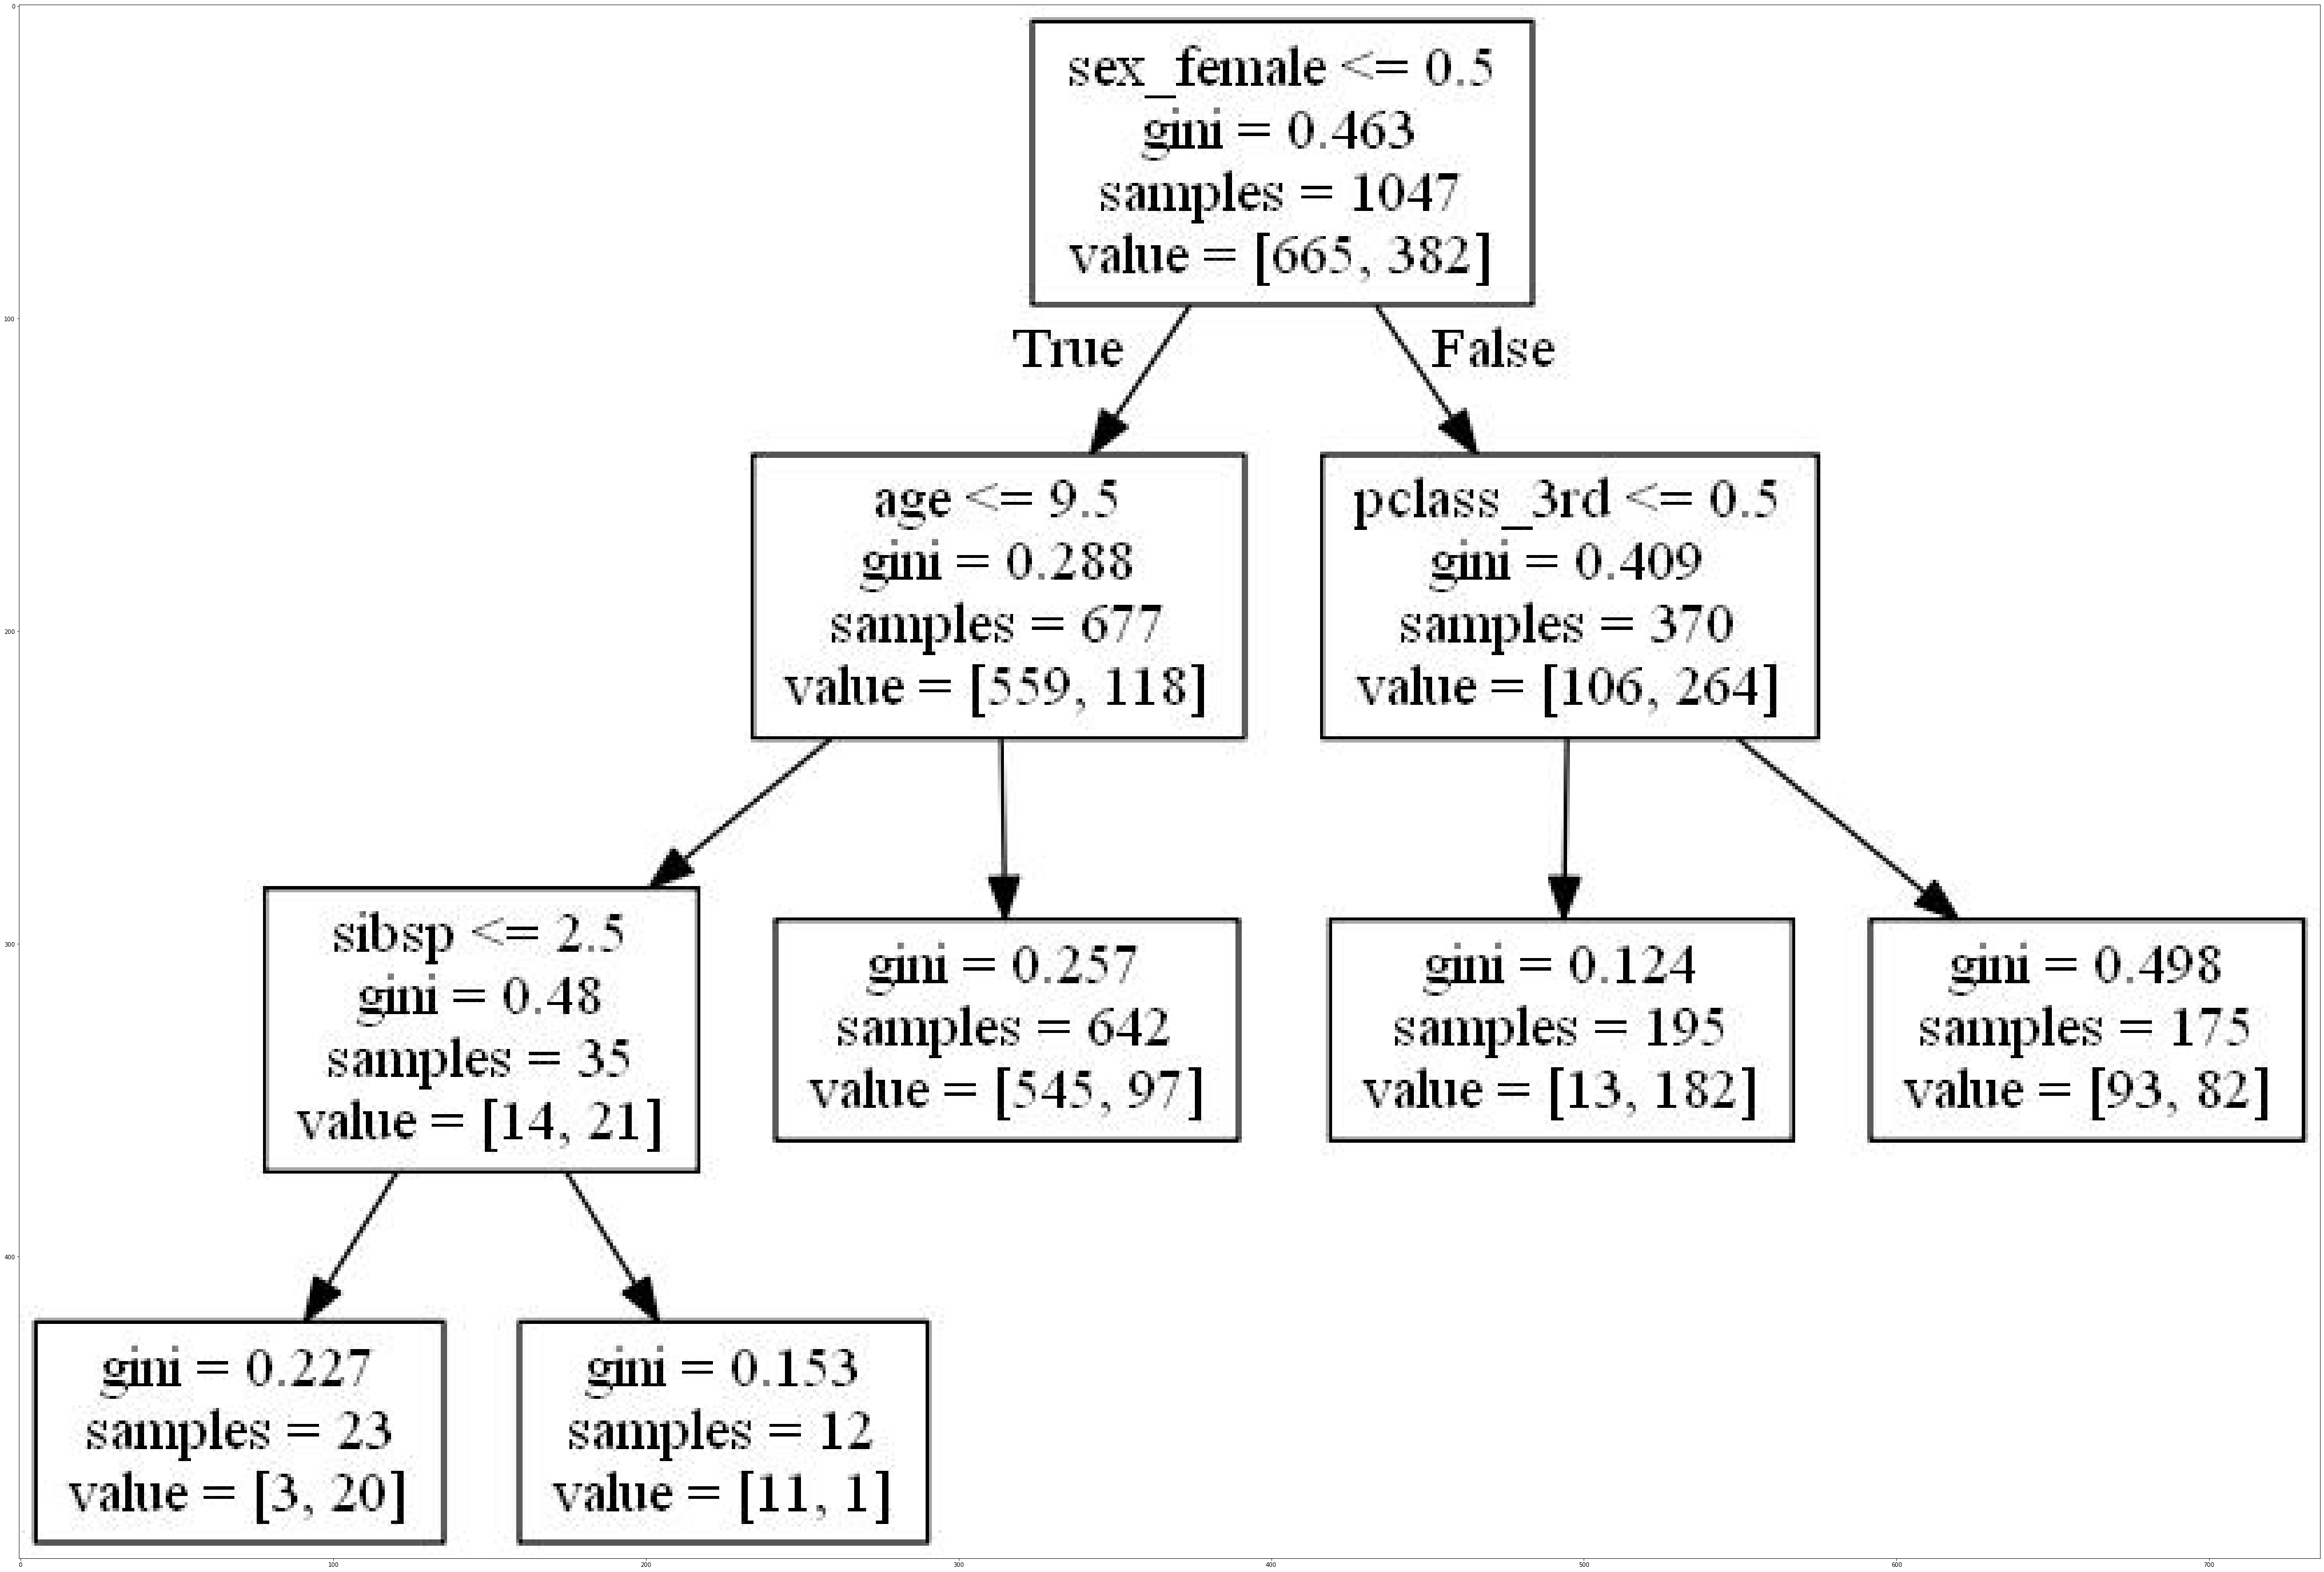

In [5]:
#decision_tree_pruned = grid.best_estimator_
decision_tree_pruned1 = tree.DecisionTreeClassifier(max_depth = 4, max_leaf_nodes = grid.best_params_['max_leaf_nodes'], min_samples_leaf = grid.best_params_['min_samples_leaf'], min_samples_split = grid.best_params_['min_samples_split'] )

decision_tree_pruned1.fit(X_train, Y_train)
final_decision_tree = tree.export_graphviz(decision_tree_pruned1, out_file=None, feature_names = X_train.columns.values)
pydot_graph = graph_from_dot_data(final_decision_tree)
pydot_graph.write_jpg('decision_tree_pruned.jpg')
img1 = plt.imread('decision_tree_pruned.jpg')
plt.figure(figsize = (100,50))
plt.imshow(img1)

In [6]:
y_predicted_train = decision_tree_pruned1.predict(X_train)
y_predicted_whole_tree_train = decision_tree.predict(X_train)
confusion_matrix_train = confusion_matrix(Y_train, y_predicted_train)
confusion_matrix_whole_tree_train = confusion_matrix(Y_train, y_predicted_whole_tree_train)
print(confusion_matrix_train, 'Pruned tree matrix for Training data')
print(confusion_matrix_whole_tree_train, 'Unpruned tree confusion matrix for training data')
print('MIsclassified (training data for whole tree)', confusion_matrix_whole_tree_train[0][1] + confusion_matrix_whole_tree_train[1][0])

group_percentages = ['{0:.4%}'.format(value) for value in confusion_matrix_train.flatten()/np.sum(confusion_matrix_train)]

print('percentage of in sample survivors predicted correctly(pruned):', group_percentages[0])
print('percentage of in sample fatalities predicted correctly(pruned):', group_percentages[3])
print('MIsclassified (training data for pruned tree)', confusion_matrix_train[0][1] + confusion_matrix_train[1][0])

y_predicted_test = decision_tree_pruned1.predict(X_test)
y_predicted_whole_tree_test = decision_tree.predict(X_test)
confusion_matrix_test = confusion_matrix(Y_test, y_predicted_test)
confusion_matrix_whole_tree_test = confusion_matrix(Y_test, y_predicted_whole_tree_test)
print(confusion_matrix_test, 'Pruned tree matrix for Testing data')
print(confusion_matrix_whole_tree_test, 'Unpruned tree confusion matrix for testing data')
print('MIsclassified (testing data for whole tree):', confusion_matrix_whole_tree_test[0][1] + confusion_matrix_whole_tree_test[1][0])

group_percentages_test = ['{0:.4%}'.format(value) for value in confusion_matrix_test.flatten()/np.sum(confusion_matrix_test)] 

print('percentage of out-of-sample survivors correctly predicted (pruned):', group_percentages_test[0])
print('percentage of out-of-sample fatalities correctly predicted (pruned):', group_percentages_test[3])
print('MIsclassified (testing data for pruned tree):', confusion_matrix_test[0][1] + confusion_matrix_test[1][0])

[[649  16]
 [180 202]] Pruned tree matrix for Training data
[[640  25]
 [ 88 294]] Unpruned tree confusion matrix for training data
MIsclassified (training data for whole tree) 113
percentage of in sample survivors predicted correctly(pruned): 61.9866%
percentage of in sample fatalities predicted correctly(pruned): 19.2932%
MIsclassified (training data for pruned tree) 196
[[140   4]
 [ 63  55]] Pruned tree matrix for Testing data
[[128  16]
 [ 49  69]] Unpruned tree confusion matrix for testing data
MIsclassified (testing data for whole tree): 65
percentage of out-of-sample survivors correctly predicted (pruned): 53.4351%
percentage of out-of-sample fatalities correctly predicted (pruned): 20.9924%
MIsclassified (testing data for pruned tree): 67
